# Analysis of NPY and Y1 in the spinal cord
Here we analyse Häring *et al* 2018 spinal cord dataset.

In [2]:
import numpy as np
import pandas as pd
import scanpy.api as sc
from collections import Counter

#Makes the text in figures editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sc.logging.print_versions()

C:\Users\jonja158\AppData\Roaming\Python\Python36\site-packages\scanpy\api\__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.8 numpy==1.16.2 scipy==1.3.1 pandas==0.23.4 scikit-learn==0.19.1 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


# Loading count matrix and Metadata

In [3]:
meta = pd.read_csv("haring_data/metadata.csv", sep = ";", index_col = 0)
adata = sc.read_csv("haring_data/counts.csv", delimiter=";", first_column_names= True).T
adata.obs["cell type"] = meta["standard_names"]
#adata.obs["strain"] = meta["strain"]

In [4]:
adata.raw = sc.pp.log1p(adata, copy=True)
#sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

# Coexpression analysis
Note that when analysing coexpression of genes on a cell to cell basis, the overlap is underestimated due to the presence of drop-out. 

The first table here is a simple coexpression table

In [5]:
#simple coexpression
genes = ["Slc17a6", "Slc32a1", "Npy1r", "Npy2r","Npy","Ucn3", "Sst","Grp","Npr1", "Grpr", "Sstr2","Pdyn"]
th = 0.0

adata_f = adata[:,genes]
overlap = dict()
for gene_i in genes:
    gene_overlap = list()
    adata_gene = adata_f[adata_f[:, adata_f.var_names == gene_i].X > th]
    for gene_j in genes:
        adata_overlap_gene = adata_gene[adata_gene[:, adata_gene.var_names == gene_j ].X > th]
        gene_overlap.append(len(adata_overlap_gene)/len(adata_gene)*100)
    overlap[gene_i] = gene_overlap+[len(adata_gene)]
    
df = pd.DataFrame(overlap, index = genes+["n cells"]).T
df.round(0)

C:\Users\jonja158\AppData\Roaming\Python\Python36\site-packages\anndata\core\anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


,Slc17a6,Slc32a1,Npy1r,Npy2r,Npy,Ucn3,Sst,Grp,Npr1,Grpr,Sstr2,Pdyn,n cells
Slc17a6,100.0,6.0,19.0,3.0,5.0,8.0,85.0,49.0,6.0,13.0,5.0,2.0,759.0
Slc32a1,7.0,100.0,13.0,9.0,71.0,1.0,25.0,7.0,4.0,1.0,40.0,23.0,655.0
Npy1r,63.0,36.0,100.0,3.0,30.0,8.0,66.0,39.0,10.0,6.0,23.0,13.0,231.0
Npy2r,25.0,66.0,9.0,100.0,71.0,0.0,36.0,18.0,1.0,4.0,22.0,11.0,85.0
Npy,7.0,79.0,12.0,10.0,100.0,1.0,25.0,7.0,4.0,1.0,38.0,22.0,590.0
Ucn3,93.0,12.0,28.0,0.0,4.0,100.0,100.0,49.0,19.0,6.0,6.0,0.0,68.0
Sst,78.0,20.0,19.0,4.0,18.0,8.0,100.0,47.0,7.0,9.0,10.0,4.0,826.0
Grp,88.0,12.0,21.0,4.0,9.0,8.0,92.0,100.0,6.0,7.0,8.0,2.0,426.0
Npr1,60.0,34.0,27.0,1.0,27.0,16.0,67.0,33.0,100.0,4.0,30.0,18.0,82.0
Grpr,94.0,9.0,13.0,3.0,8.0,4.0,70.0,27.0,3.0,100.0,3.0,0.0,103.0


Now we want to analyse overlap between cells that express a combination of two genes and one other gene.

Gene 1 **AND** Gene 2 **AND** Gene 3

In [6]:
#Overlapping expression table
from itertools import permutations, product, combinations
th = 0.0

genesets = list(combinations(genes, 2))


In [7]:
adata_f = adata[:,genes]
overlap = dict()
for geneset in genesets:
    gene_overlap = list()
    gene1 = adata_f.obs_vector(geneset[0]) > th
    gene2 = adata_f.obs_vector(geneset[1]) > th
    set_and = np.logical_and(gene1, gene2)
    adata_gene = adata_f[set_and]
    for gene_j in genes:
        try:
            adata_overlap_gene = adata_gene[adata_gene.obs_vector(gene_j) > th]
        except: adata_overlap_gene=list()
        try:
            gene_overlap.append(len(adata_overlap_gene)/len(adata_gene)*100)
        except:  gene_overlap.append("nan")
    overlap[geneset] = gene_overlap+[len(adata_gene)]
    
df = pd.DataFrame(overlap, index = genes+["n cells"]).T
print(df.round(1))

C:\Users\jonja158\AppData\Roaming\Python\Python36\site-packages\anndata\core\anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


                 Slc17a6  Slc32a1    Npy1r     Npy2r      Npy      Ucn3  \
Slc17a6 Slc32a1      100      100  33.3333   8.33333  41.6667   14.5833   
        Npy1r        100  10.9589      100         0  6.84932   11.6438   
        Npy2r        100  19.0476        0       100  19.0476         0   
        Npy          100  51.2821   25.641   10.2564      100   7.69231   
        Ucn3         100  11.1111  26.9841         0   4.7619       100   
        Sst          100  6.18238  19.7836   2.31839  4.63679   9.73725   
        Grp          100  5.09383  21.1796   3.21716  3.48525   8.31099   
        Npr1         100  4.08163  24.4898   2.04082  6.12245   24.4898   
        Grpr         100  6.18557  13.4021   3.09278  5.15464   3.09278   
        Sstr2        100  23.6842  23.6842   2.63158  28.9474   10.5263   
        Pdyn         100       25       25         0  33.3333         0   
Slc32a1 Npy1r    19.0476      100      100   8.33333  66.6667    4.7619   
        Npy2r    7.14286 

In [8]:
writer = pd.ExcelWriter('output.xlsx')
df.to_excel(writer,'overlapping')


Now we want to analyse cells that express one gene but not another and overlap with other genes.

(Gene 1 **NOT** Gene 2) **AND** Gene 3

In [9]:
# non Overlapping expression table
adata_f = adata[:,genes]
overlap = dict()
for geneset in genesets:
    gene_overlap = list()
    gene1 = adata_f.obs_vector(geneset[0]) > th
    gene2 = adata_f.obs_vector(geneset[1]) <= th #not coexpressed
    set_and = np.logical_and(gene1, gene2)
    adata_gene = adata_f[set_and]
    for gene_j in genes:
        try:
            adata_overlap_gene = adata_gene[adata_gene.obs_vector(gene_j) > th]
        except: adata_overlap_gene=list()
        try:
            gene_overlap.append(len(adata_overlap_gene)/len(adata_gene)*100)
        except:  gene_overlap.append("nan")
    overlap[geneset] = gene_overlap+[len(adata_gene)]
    
df = pd.DataFrame(overlap, index = genes+["n cells"]).T
print(df.round(1))

                 Slc17a6  Slc32a1    Npy1r    Npy2r      Npy      Ucn3  \
Slc17a6 Slc32a1      100        0  18.2841    2.391  2.67229   7.87623   
        Npy1r        100  5.22023        0  3.42577  4.73083   7.50408   
        Npy2r        100  5.96206  19.7832        0  4.74255   8.53659   
        Npy          100  3.88889  18.8889  2.36111        0   8.33333   
        Ucn3         100   5.8908  18.5345  3.01724  5.17241         0   
        Sst          100  7.14286  16.0714  5.35714  8.03571         0   
        Grp          100  7.51295  17.3575  2.33161  6.73575   8.29016   
        Npr1         100  6.47887  18.8732   2.8169  5.07042    7.1831   
        Grpr         100  6.34441  20.0906  2.71903  5.13595   9.06344   
        Sstr2        100  5.40915  19.0014  2.77393   3.8835   8.18308   
        Pdyn         100   6.0241  19.1432  2.81124  4.68541   8.43373   
Slc32a1 Npy1r     5.6042      100        0  8.58144  71.6287  0.700525   
        Npy2r    7.34558      100  12.

In [10]:
df.to_excel(writer,'non overlapping')
writer.save()

We also want to visualize the expression of genes among all cell identities. This we can do with a dotplot, where the size of the dot represents the percent of cells in a groups that express >0 reads of a gene, and the color the mean expression level in the group.

... storing 'cell type' as categorical


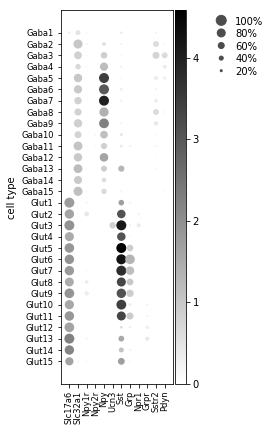

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[2.05, 0, 0.2, 0.5, 0.25])

In [11]:
sc.pl.dotplot(adata, figsize=(3,7), var_names=genes, groupby="cell type", smallest_dot=0, color_map="gray_r", save = "geneExpression.pdf")